# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Data retrival from influx

In [2]:
!pip3 install influxdb_client

You should consider upgrading via the 'C:\Users\andre\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
token = '0-boCREZ1XTzYhmT3RYogxFDtraRzOEZsMYNxjp0mBOWHCif47lUv2UddrAfyJUwupk33ci92-aHHFWhjv2pRg=='
bucket = 'temperature'
org = 'iot_group'
client = InfluxDBClient(url="http://192.168.43.177:8086", token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [4]:
query = 'from(bucket: "temperature")' \
  '|> range(start:2022-08-10T15:00:00Z, stop:2022-09-20T15:00:00Z)'

In [5]:
result = client.query_api().query(org=org, query=query)

-Exploiting the query results in order to obtain a dataframe

In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

## Implementation Temperature Predictor

### ARIMA

In [61]:
dataset_path = "../datasets/dataset1.csv"
df = pd.read_csv(dataset_path)
df.head()

,result,table,_start,_stop,_time,_value,_field,_measurement,clientId,lat,lng,prediction
0,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:02.3585624Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
1,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:04.8724766Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
2,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:07.3884615Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
3,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:09.8994101Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
4,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:12.414701Z,29.5,temperature,val,diubi-esp-32,42.84629,13.904817,no


In [62]:
df.head()

,result,table,_start,_stop,_time,_value,_field,_measurement,clientId,lat,lng,prediction
0,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:02.3585624Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
1,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:04.8724766Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
2,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:07.3884615Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
3,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:09.8994101Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
4,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:12.414701Z,29.5,temperature,val,diubi-esp-32,42.84629,13.904817,no


In [ ]:
#evolution over time of our data
plot_cols = ['_value']
plot_features = df[plot_cols]
plot_features.index = df['_time']
print(df.to_string())
_ = plot_features.plot(subplots=True)



In [64]:
df.describe()

,result,table,_value,lat,lng
count,0.0,3637.000000,3637.000000,3.637000e+03,3.637000e+03
mean,NaN,0.034094,32.535771,4.284629e+01,1.390482e+01
std,NaN,0.181496,0.645202,7.106404e-15,1.776601e-15
min,NaN,0.000000,29.400000,4.284629e+01,1.390482e+01
25%,NaN,0.000000,32.500000,4.284629e+01,1.390482e+01
50%,NaN,0.000000,32.800000,4.284629e+01,1.390482e+01
75%,NaN,0.000000,32.900000,4.284629e+01,1.390482e+01
max,NaN,1.000000,33.100000,4.284629e+01,1.390482e+01


In [65]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['_value'] [:splitPoint]
test = df ['_value'] [splitPoint:]

In [ ]:
!pip install statsmodels

In [66]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.908645
p-value: 0.001972


In [67]:
train_new = train.diff().dropna()
result = adfuller(train_new)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -48.817876
p-value: 0.000000


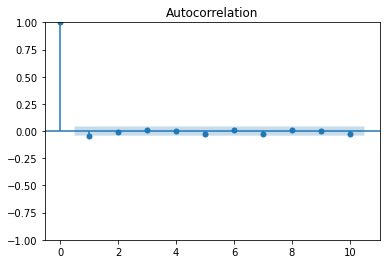

In [68]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_new,lags=10)
plt.show()

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


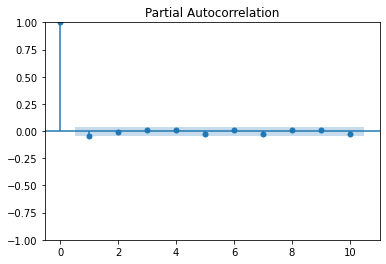

In [69]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [ ]:
#Step 6; Apply ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(0,0,1))
  model_fit = model. fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

Test RMSE: 0.207


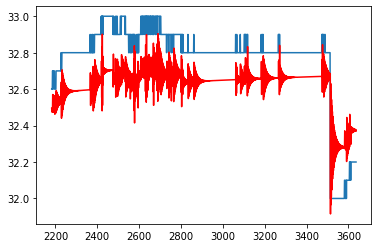

In [72]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

### Prophet

In [ ]:
%pip install conda

In [25]:
%pip conda install -c conda-forge fbprophet -y

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "conda"



In [27]:
!pip install --upgrade plotly

You should consider upgrading via the 'C:\Users\andre\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
from prophet import Prophet

In [29]:
model_params = {"daily_seasonality": False, "weekly_seasonality": False, "yearly_seasonality": True, "seasonality_mode": "multiplicative", "growth": "logistic"}

In [30]:
model = Prophet(model_params)

ValueError: Parameter "growth" should be "linear", "logistic" or "flat".

In [ ]:
model.plot_components(forecast)
model.plot(forecast)

## Implementation Humidity Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/hum.csv"
df = pd.read_csv(dataset_path)
df.head()

,409151bfa0cc,409151bfa0cc.1
0,2022-06-05 23:03:12,49.9
1,2022-06-05 23:03:15,49.9
2,2022-06-05 23:03:17,49.9
3,2022-06-05 23:03:20,49.8
4,2022-06-05 23:03:22,49.8


In [ ]:
df = df.rename(columns={"409151bfa0cc" : 'time', "409151bfa0cc.1" : 'y'})
df.head()

,time,y
0,2022-06-05 23:03:12,49.9
1,2022-06-05 23:03:15,49.9
2,2022-06-05 23:03:17,49.9
3,2022-06-05 23:03:20,49.8
4,2022-06-05 23:03:22,49.8


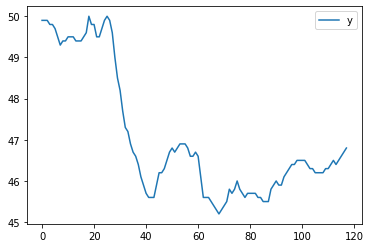

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,118.0,47.049153,1.572344,45.2,45.825,46.45,48.425,50.0


In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.015842
p-value: 0.747443


In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.107289
p-value: 0.000942


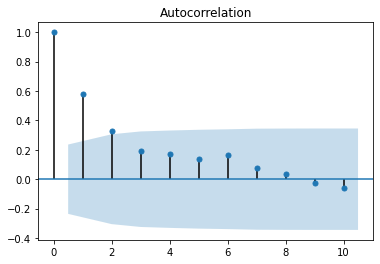

In [ ]:
fig = tsaplots.plot_acf(train_new, lags=10)
plt.show()

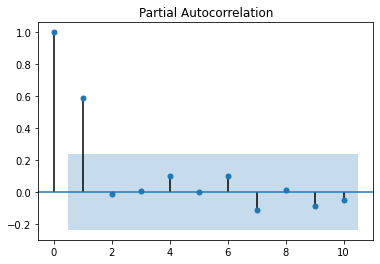

In [ ]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [ ]:
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

Test RMSE: 0.118


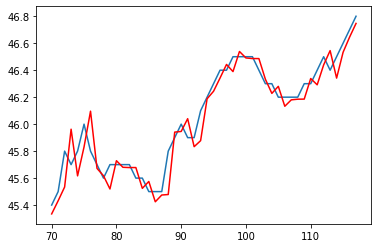

In [ ]:
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd.DataFrame(predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

## Implement Gas Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/gas.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,Time,y
0,2022-06-05 21:07:11,4095
1,2022-06-05 21:07:13,4095
2,2022-06-05 21:07:16,4095
3,2022-06-05 21:07:18,4095
4,2022-06-05 21:07:21,4095


In [ ]:
df['y'].size

4288

In [ ]:
df['y'][0:4288] = 4095

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


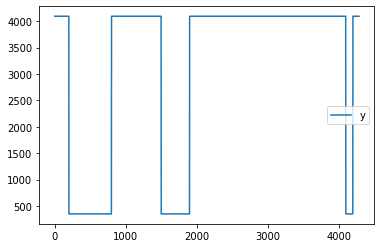

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df['y'][3000:4000] = [4095 for i in range(0,1000)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,4288.0,3134.295709,1635.698257,350.0,350.0,4095.0,4095.0,4095.0


In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.50)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

Check for stationarity 

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.005413
p-value: 0.284205


In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -46.260134
p-value: 0.000000


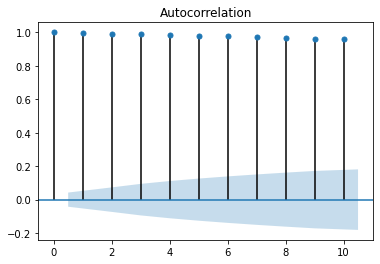

In [ ]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train, lags=10)
plt.show()

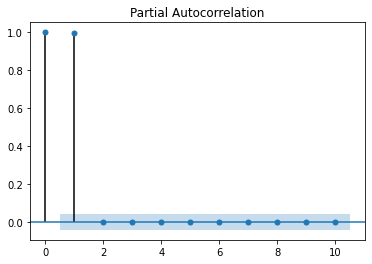

In [ ]:
fig = tsaplots.plot_pacf(train, lags=10)
plt.show()

In [ ]:
# Apply ARIMA model
from statsmodels.tsa.arima_model import ARIMA
history = list(np.array([x for x in train_new]).astype('float64'))
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

Test RMSE: 180.939


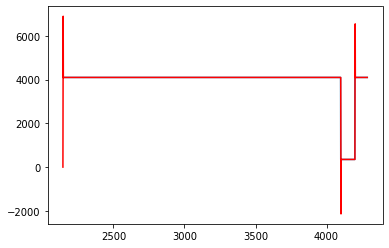

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

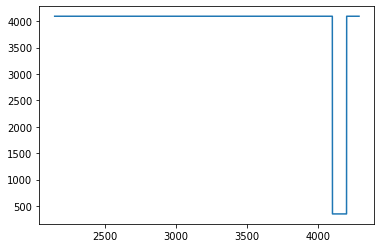

In [ ]:
plt.plot(test)


In [ ]:
import pickle
pickle.dump(model_fit, open('gas-model', 'wb'))